<a href="https://colab.research.google.com/github/Coral277/tutorial/blob/main/optimization_of_two_dimensional_polygon_packing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Experiment 1: Random placement strategy placement
Experiment 1 - Fitness: 0.06416138057837219
Running Experiment 2: Bottom left strategy placement
Experiment 2 - Fitness: 0.05023926086354427
Running Experiment 3: Center focus strategy placement
Experiment 3 - Fitness: 0.0641613805783722
Running Experiment 4: Center focus strategy placement
Experiment 4 - Fitness: 0.06416138057837222


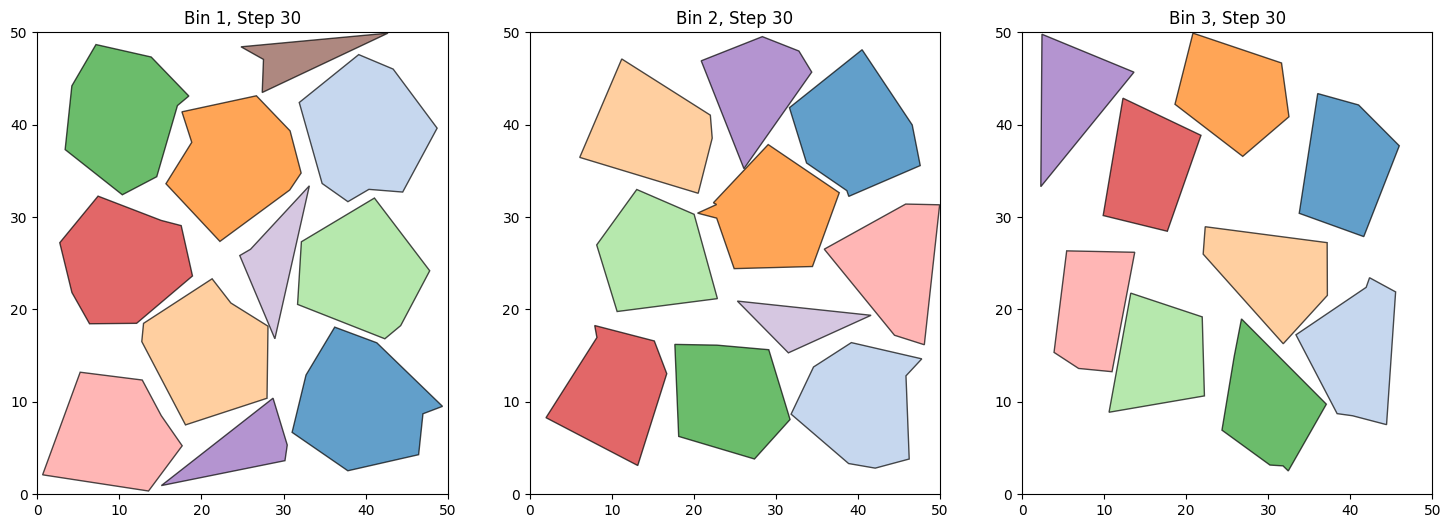

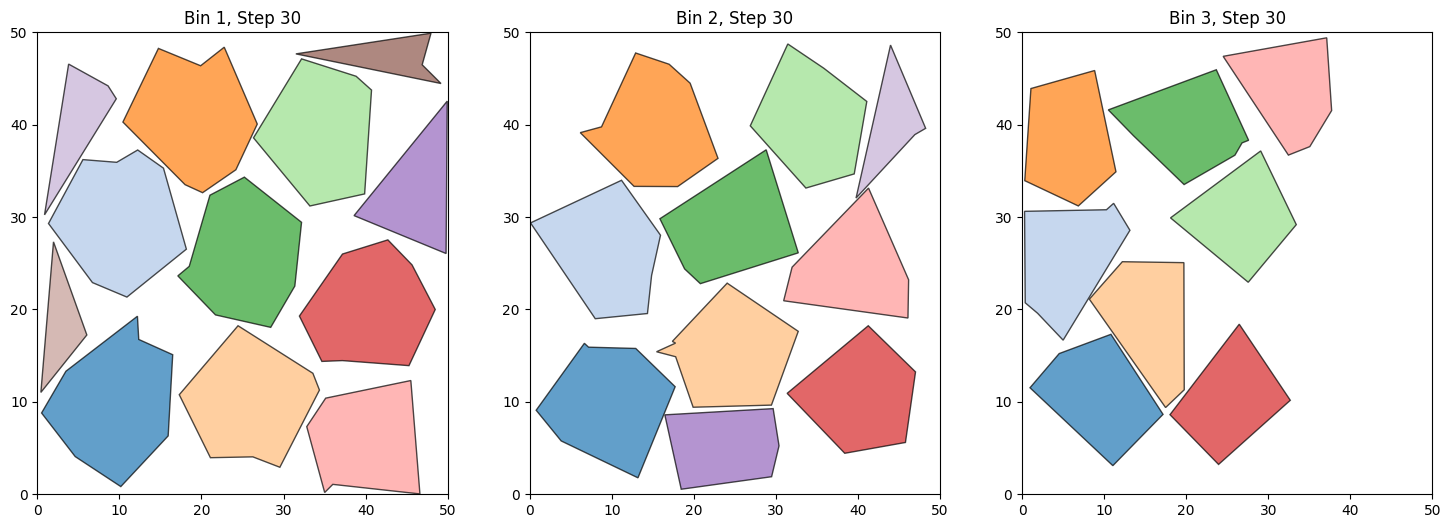

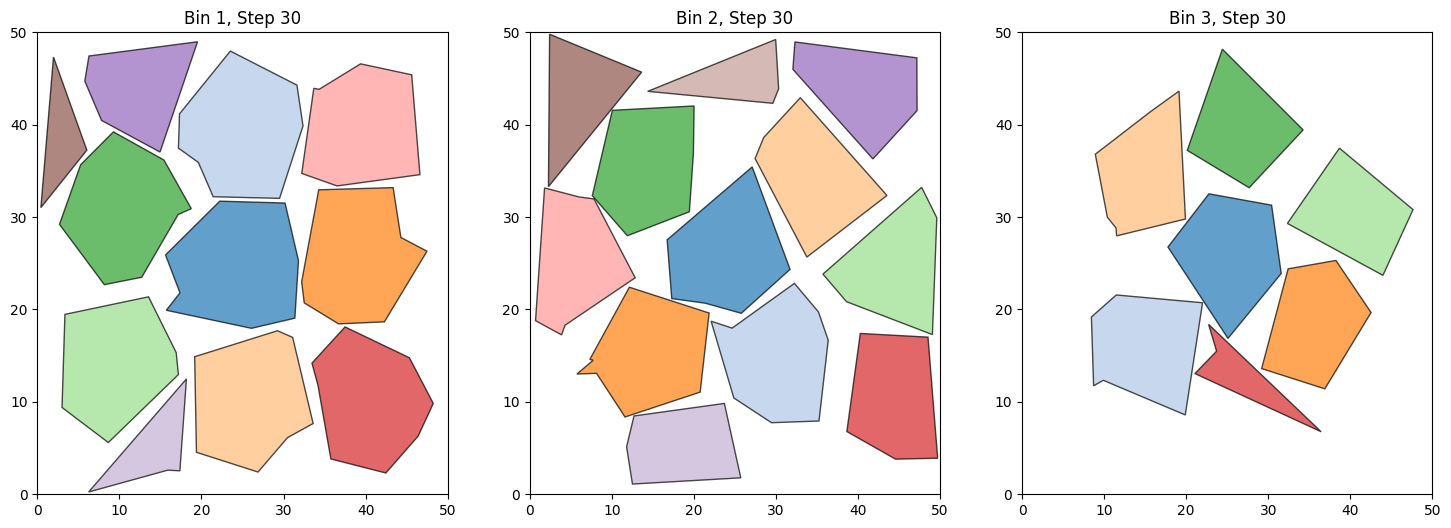

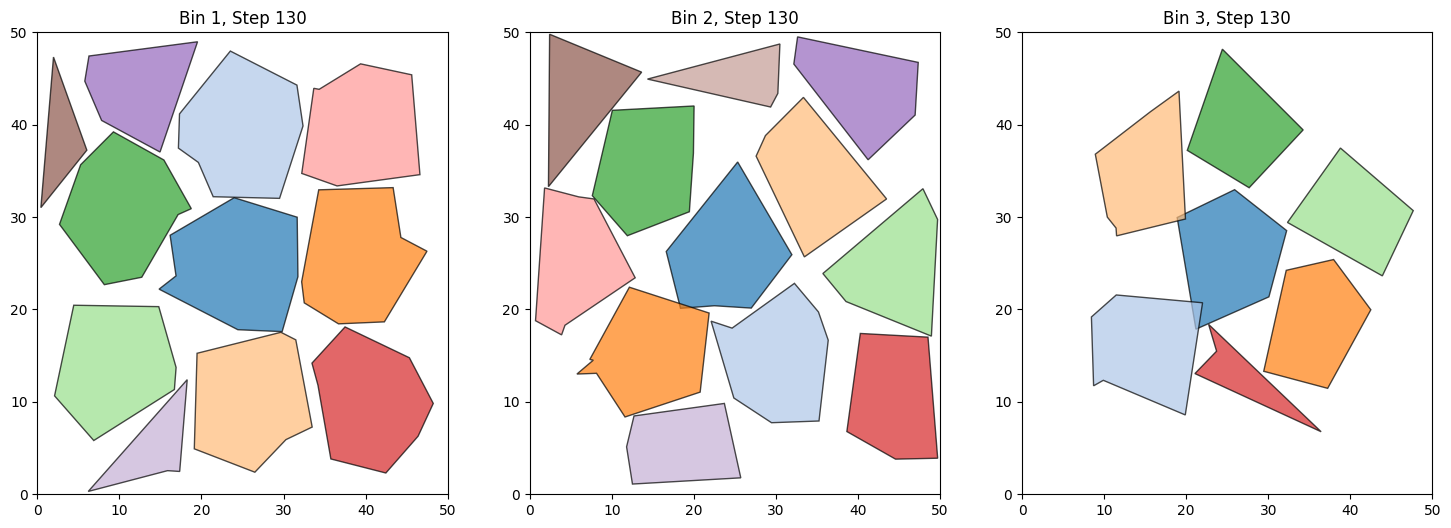

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import translate, rotate, scale
import random
from matplotlib.animation import FuncAnimation

def generate_random_polygon(avg_radius, spikiness, num_vertices):
    angle_steps = np.random.uniform(0, 2 * np.pi, num_vertices)
    angle_steps /= angle_steps.sum() / (2 * np.pi)

    points = []
    angle = random.uniform(0, 2 * np.pi)

    for step in angle_steps:
        r = random.uniform(avg_radius * (1 - spikiness), avg_radius * (1 + spikiness))
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        points.append((x, y))
        angle += step

    poly = Polygon(points)
    return poly if poly.is_valid else generate_random_polygon(avg_radius, spikiness, num_vertices)

def scale_polygons(polygons, scale_factor):
    return [scale(p, xfact=scale_factor, yfact=scale_factor, origin='centroid') for p in polygons]

def calculate_proximity_factor(polygon, bin_width, bin_height):
    if polygon is None or not polygon.is_valid:
        return float('inf')

    center_x, center_y = bin_width / 2, bin_height / 2
    poly_center = polygon.centroid
    return np.sqrt((poly_center.x - center_x) ** 2 + (poly_center.y - center_y) ** 2)

def calculate_density(polygons, max_distance):
    total_polygon_area = sum(p.area for p in polygons if p is not None and p.is_valid)
    circumscribed_circle_area = np.pi * (max_distance ** 2)
    return total_polygon_area / circumscribed_circle_area if circumscribed_circle_area > 0 else 0


def calculate_fitness(polygons, bin_width, bin_height):
    max_distance = max(calculate_proximity_factor(p, bin_width, bin_height) for p in polygons)
    density = calculate_density(polygons, max_distance)
    proximity_factor = 1 / (max_distance + 1)
    return density * proximity_factor


def sort_polygons_by_djd(polygons):
    return sorted(polygons, key=lambda p: (p.area, p.length), reverse=True)

def is_valid_placement(polygon, bin_width, bin_height, bin_polygons, buffer_size=0.1):
    return inside_bin(polygon, bin_width, bin_height) and no_overlap(polygon, bin_polygons, buffer_size)

def inside_bin(polygon, bin_width, bin_height):
    minx, miny, maxx, maxy = polygon.bounds
    return (0 <= minx <= bin_width and 0 <= maxx <= bin_width and
            0 <= miny <= bin_height and 0 <= maxy <= bin_height)

def no_overlap(polygon, other_polygons, buffer_size=2.0):
    if polygon is None or not polygon.is_valid:
        return False
    for other in other_polygons:
        if other is not None:
            if polygon.distance(other) < buffer_size:
                return False
    return True


def random_placement_strategy(best_position, new_position, bin_width, bin_height):
    return new_position if random.random() > 0.5 else best_position

def bottom_left_strategy(best_position, new_position, bin_width, bin_height):
    if not best_position:
        return new_position
    curr_x, curr_y = best_position.bounds[:2]
    new_x, new_y = new_position.bounds[:2]
    return new_position if new_x < curr_x or (new_x == curr_x and new_y < curr_y) else best_position


def center_focus_strategy(best_position, new_position, bin_width, bin_height):
    if not best_position:
        return new_position
    return new_position if calculate_distance_to_center(new_position, bin_width, bin_height) < calculate_distance_to_center(best_position, bin_width, bin_height) else best_position

def calculate_distance_to_center(polygon, bin_width, bin_height):
    center_x, center_y = bin_width / 2, bin_height / 2
    poly_center = polygon.centroid
    return np.sqrt((poly_center.x - center_x) ** 2 + (poly_center.y - center_y) ** 2)

def place_polygon(polygon, bin_width, bin_height, bin_polygons, step_size, strategy):
    best_position = None
    buffer_size = 0.1

    for angle in range(0, 360, 15):
        rotated_polygon = rotate(polygon, angle, origin='centroid')
        for x_offset in np.arange(0, bin_width, step_size):
            for y_offset in np.arange(0, bin_height, step_size):
                moved_polygon = translate(rotated_polygon, xoff=x_offset, yoff=y_offset)
                if is_valid_placement(moved_polygon, bin_width, bin_height, bin_polygons, buffer_size):
                  best_position = strategy(best_position, moved_polygon, bin_width, bin_height) if best_position else moved_polygon
    return best_position

def mutate_polygons(packed_bins, bin_width, bin_height, mutation_rate, step_size):
    new_bins = []
    buffer_size = 1.0
    for bin_polygons in packed_bins:
        new_bin = []
        for poly in bin_polygons:
            if poly is None or not poly.is_valid:
                new_bin.append(poly)
                continue

            if random.random() < mutation_rate:
                angle = random.uniform(-3, 3)
                rotated_poly = rotate(poly, angle, origin='centroid')
                x_offset = random.uniform(-0.02 * step_size, 0.02 * step_size)
                y_offset = random.uniform(-0.02 * step_size, 0.02 * step_size)
                moved_poly = translate(rotated_poly, xoff=x_offset, yoff=y_offset)

                if moved_poly.is_valid and no_overlap(moved_poly, new_bin, buffer_size) and inside_bin(moved_poly, bin_width, bin_height):
                    new_bin.append(moved_poly)
                else:
                    new_bin.append(poly)
            else:
                new_bin.append(poly)
        new_bins.append(new_bin)
    return new_bins

def genetic_algorithm(polygons, bin_width, bin_height, generations=100, mutation_rate=0.15, strategy=None):
    polygons = sort_polygons_by_djd(polygons)

    steps = []
    bins = [[]]
    best_fitness = float('-inf')
    best_solution = None

    for poly in polygons:
        placed = False
        for bin_polygons in bins:
            placed_poly = place_polygon(poly, bin_width, bin_height, bin_polygons, step_size=5, strategy=strategy)
            if placed_poly:
                bin_polygons.append(placed_poly)
                steps.append([list(bin_polygons) for bin_polygons in bins if bin_polygons])
                placed = True
                break
        if not placed:
            new_bin = []
            bins.append(new_bin)
            placed_poly = place_polygon(poly, bin_width, bin_height, new_bin, step_size=5, strategy=strategy)
            new_bin.append(placed_poly)
            steps.append([list(bin_polygons) for bin_polygons in bins if bin_polygons])

    current_fitness = calculate_fitness([poly for bin_polygons in bins for poly in bin_polygons], bin_width, bin_height)
    best_fitness = current_fitness
    best_solution = bins.copy()

    for generation in range(generations):
        new_bins = mutate_polygons(bins, bin_width, bin_height, mutation_rate, step_size=1)

        new_fitness = calculate_fitness([poly for bin_polygons in new_bins for poly in bin_polygons], bin_width, bin_height)

        if new_fitness > best_fitness:
            best_fitness = new_fitness
            best_solution = new_bins.copy()

        steps.append([list(bin_polygons) for bin_polygons in new_bins if bin_polygons])
        bins = new_bins

    return steps, best_solution, best_fitness

def animate_placements(steps, bin_width, bin_height, experiment_index):
    max_bins = max(len(step) for step in steps)
    fig, axes = plt.subplots(1, max_bins, figsize=(6 * max_bins, 6))
    if max_bins == 1: axes = [axes]
    colors = plt.get_cmap('tab20')

    def update(frame):
        for bin_index, ax in enumerate(axes):
            ax.clear()
            ax.set_xlim(0, bin_width)
            ax.set_ylim(0, bin_height)
            if bin_index < len(steps[frame]):
                for poly_index, poly in enumerate(steps[frame][bin_index]):
                    if poly and poly.is_valid:
                        x, y = poly.exterior.xy
                        ax.fill(x, y, alpha=0.7, facecolor=colors(poly_index % 20), edgecolor='black')
            ax.set_title(f"Bin {bin_index + 1}, Step {frame + 1}")

    anim = FuncAnimation(fig, update, frames=len(steps), repeat=False)
    anim.save(f'packing_animation_experiment_{experiment_index}.gif', writer='pillow', fps=10)
    return anim


def run_experiment(polygons, experiment_index, num_polygons, bin_width, bin_height, placement_strategy, generations=0, mutation_rate=0.0, optimize=False):
    print(f"Running Experiment {experiment_index}: {placement_strategy.__name__.replace('_', ' ').capitalize()} placement")

    steps = []
    bins = [[]]

    if optimize:
        steps, best_solution, best_fitness = genetic_algorithm(polygons, bin_width, bin_height, generations, mutation_rate, strategy=placement_strategy)
        print(f"Experiment {experiment_index} - Fitness: {best_fitness}")
    else:
        for poly in polygons:
            placed = False
            for bin_polygons in bins:
                placed_poly = place_polygon(poly, bin_width, bin_height, bin_polygons, step_size=5, strategy=placement_strategy)
                if placed_poly:
                    bin_polygons.append(placed_poly)
                    placed = True
                    steps.append([list(bin) for bin in bins])
                    break
            if not placed:
                new_bin = []
                bins.append(new_bin)
                new_bin.append(place_polygon(poly, bin_width, bin_height, new_bin, step_size=5, strategy=placement_strategy))
                steps.append([list(bin) for bin in bins])

        current_fitness = calculate_fitness([poly for bin_polygons in bins for poly in bin_polygons], bin_width, bin_height)
        print(f"Experiment {experiment_index} - Fitness: {current_fitness}")

    animate_placements(steps, bin_width, bin_height, experiment_index)


def run_all_experiments():
    bin_width = 50
    bin_height = 50
    num_polygons = 30

    polygons = [generate_random_polygon(avg_radius=10, spikiness=0.2, num_vertices=random.randint(3, 8)) for _ in range(num_polygons)]
    polygons = sort_polygons_by_djd(polygons)
    polygons = scale_polygons(polygons, 0.8)

    # Experiment 1: Random placement
    run_experiment(polygons, 1, num_polygons, bin_width, bin_height, random_placement_strategy, optimize=False)

    # Experiment 1: Bottom-Left-Fill placement heuristic
    run_experiment(polygons, 2, num_polygons, bin_width, bin_height, bottom_left_strategy, optimize=False)

    # Experiment 3: Center-focused placement strategy
    run_experiment(polygons, 3, num_polygons, bin_width, bin_height, center_focus_strategy, optimize=False)

    # Experiment 4: Center-focused placement strategy with genetic algorithm
    run_experiment(polygons, 4, num_polygons, bin_width, bin_height, center_focus_strategy, generations=100, mutation_rate=0.5, optimize=True)

run_all_experiments()
